# N1 Mean Analysis
## 75-125 ms

## Load necessary libraries
If any of these don't load, you'll need to install them. Assuming you installed Jupyter through Anaconda, you would do the following to install a package
`conda install -c r r-[pkgName]`
e.g., to install ggplot2 you would do:
`conda install -c r r-ggplot2`

In [1]:
R.home()

[1] "/opt/conda/lib/R"

In [2]:
library(ggplot2)
library(mgcv)
library(parallel)
library(plyr)
library(tidyr)
library(data.table)
library(viridis)
# library(ggthemes)
library(nlme)

Loading required package: nlme
This is mgcv 1.8-29. For overview type 'help("mgcv-package")'.
Loading required package: viridisLite


## Set parameters for this analysis

In [3]:
CurTimeWin = '75-125'
component = 'N1_mean'

topdir = getwd()
expt = 'eLearn'
outdir = (paste(topdir,'/R-data/Stats_Output',sep=''))
dir.create(outdir, showWarnings = FALSE)
# Functions we'll use later
source(paste(topdir,'/NCIL_functions.R',sep=""))

# source(paste(topdir,'/romr.fnc.R',sep=""))


# num parallel processes for bam(). Should be less than the number of threads supported by your CPU
num_cores = 4

options("scipen"=100, "digits"=5)  # force decimal instead of scientific notation

In [4]:
subjects = c('01','02','03','04','05','06','07','08','09','10','11','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','37','38','39','40','41','42','43','44','45','48','49','50','51','52')

## Load Data

In [5]:
dat  <- {}
for(s in 1:length(subjects)) {
    infile <- paste(topdir, '/R-data/', subjects[s], '_', component, '_', CurTimeWin, '.csv',sep="")
    print(infile)
    tmpdat <- read.csv(infile) 
    tmpdat$Subj <- as.factor(subjects[s])
    tmplong <- gather(tmpdat, channel, meanAmpl, Fp1:VEOG) 
    tmplong$channel = as.factor(tmplong$channel)
    dat  <- rbind(dat, tmplong)
    }

setwd(topdir)

[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/01_N1_mean_75-125.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/02_N1_mean_75-125.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/03_N1_mean_75-125.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/04_N1_mean_75-125.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/05_N1_mean_75-125.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/06_N1_mean_75-125.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/07_N1_mean_75-125.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/08_N1_mean_75-125.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/09_N1_mean_75-125.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/10_N1_mean_75-125.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/

In [6]:
colnames(dat)[1] <- 'epoch'
colnames(dat)[2] <- 'condition'

In [7]:
head(dat) # displaying first 6? list continues for each subject, each channel and each epoch?

epoch,condition,Subj,channel,meanAmpl
<int>,<fct>,<fct>,<fct>,<dbl>
0,Beep_Start,01,Fp1,21.7879
1,Unlabelled/Standard,01,Fp1,-9.7580
2,Unlabelled/Standard,01,Fp1,-10.2579
3,Unlabelled/Standard,01,Fp1,-9.2794
4,Unlabelled/Standard,01,Fp1,-3.3491
5,Unlabelled/Standard,01,Fp1,4.7384


In [8]:
summary(dat)

     epoch                    condition            Subj        
 Min.   :   0   Unlabelled/Standard:4270230   11     : 115124  
 1st Qu.: 826   Unlabelled/Oddball : 843608   18     : 114512  
 Median :1653   MW2/Standard       :  65994   48     : 114512  
 Mean   :1654   MW1/Standard       :  50048   03     : 114478  
 3rd Qu.:2480   MW3/Standard       :  48722   21     : 114444  
 Max.   :3385   MW4/Standard       :  35394   38     : 114444  
                (Other)            :  83266   (Other):4709748  
    channel           meanAmpl      
 C3     : 158743   Min.   :-899.87  
 C4     : 158743   1st Qu.:  -4.79  
 C5     : 158743   Median :  -0.56  
 C6     : 158743   Mean   :  -0.71  
 CP3    : 158743   3rd Qu.:   3.40  
 CP4    : 158743   Max.   : 908.14  
 (Other):4444804                    

### Assign ROI labels to electrodes we will analyze, then drop remaining electrodes

Let's not use these in the initial analysis. We should keep the working code here just in case.

In [9]:
dat$ROI = 'NA' # which electrodes WILL we analyze? Should I focus just on the Pz/POz region?

dat$ROI<-rep('0',times=nrow(dat))

occipital = c('POz', 'PO7', 'PO8', 'Oz', 'O1', 'O2')

parietal = c('Pz', 'P3', 'P4', 'CPz', 'CP3', 'CP4')

frontal = c('Fz', 'Cz', 'C3', 'C4', 'F3', 'F4')

which(dat$channel%in%occipital)->x
dat$ROI[x]<-"Occipital" 

which(dat$channel%in%parietal)->x
dat$ROI[x]<-"Parietal" 

which(dat$channel%in%frontal)->x
dat$ROI[x]<-"Frontal" 

dat$ROI <- factor(dat$ROI, levels = c("Occipital", "Parietal", "Frontal"))

# dat = droplevels(dat)
dat <- dat %>% drop_na(ROI)

In [10]:
dat <- dat[ which(dat$condition!='Beep_Start' & 
                  dat$condition!='Experience_Sample' & 
                  dat$condition!='Unlabelled/Standard' & 
                  dat$condition!='Unlabelled/Oddball'),]

In [11]:
dat <- dat %>%  separate(condition, c("MentalState", "StimType"), "/")

In [12]:
dat$StimType <- as.factor(dat$StimType)

which(dat$MentalState%in%'MW1') -> x
dat$MentalState[x] <- 'MW1'
which(dat$MentalState%in%'MW2') -> x
dat$MentalState[x] <- 'MW2'
which(dat$MentalState%in%'MW3') -> x
dat$MentalState[x] <- 'MW3'
which(dat$MentalState%in%'MW4') -> x
dat$MentalState[x] <- 'MW4'
which(dat$MentalState%in%'MW5') -> x
dat$MentalState[x] <- 'MW5'
dat$MentalState <- as.factor(dat$MentalState)

In [13]:
summary(dat)

     epoch      MentalState     StimType           Subj           channel     
 Min.   : 171   MW1:31500   Oddball : 21582   03     :  2880   C3     : 7448  
 1st Qu.: 493   MW2:41634   Standard:112482   15     :  2880   C4     : 7448  
 Median :1943   MW3:30672                     39     :  2880   CP3    : 7448  
 Mean   :1685   MW4:22446                     01     :  2862   CP4    : 7448  
 3rd Qu.:2615   MW5: 7812                     20     :  2862   CPz    : 7448  
 Max.   :3384                                 23     :  2862   Cz     : 7448  
                                              (Other):116838   (Other):89376  
    meanAmpl              ROI       
 Min.   :-71.054   Occipital:44688  
 1st Qu.: -5.375   Parietal :44688  
 Median : -0.782   Frontal  :44688  
 Mean   : -0.886                    
 3rd Qu.:  3.709                    
 Max.   : 81.628                    
                                    

## Create Random Effects Variables

Create variable coding the condition x Subj random effects. This serves to address any heteroscedasticity (unequal variance) across conditions, and remove uninteresting, subject-specific noise.

In [14]:
dat$electrodebySubj = as.factor(paste(as.character(dat$Subj)
                                , as.character(dat$channel),
                                 sep = "_"))


In [15]:
dat$StimTypebySubj = as.factor(paste(as.character(dat$Subj)
                                , as.character(dat$StimType),
                                 sep = "_"))

In [16]:
dat$MentalStatebySubj = as.factor(paste(as.character(dat$Subj)
                                , as.character(dat$MentalState),
                                 sep = "_"))

## Run initial full model to identify and remove outliers

Now run the model

In [17]:
m0 <- bam(meanAmpl ~ StimType * MentalState 
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1)

In [18]:
dat <- romr.fnc(m0, dat, trim=2.5)$data

m1 <- bam(meanAmpl ~ StimType * MentalState 
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1)

n.removed = 3175 
percent.removed = 2.3683 


#### Find and remove outliers, then update model


Method: fREML   Optimizer: perf newton
full convergence after 7 iterations.
Gradient range [-0.000051911,-0.00000000052335]
(score 468925 & scale 63.831).
Hessian positive definite, eigenvalue range [22.264,67027].
Model rank =  58 / 58 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

          k'  edf k-index p-value
s(Subj) 48.0 45.8      NA      NA


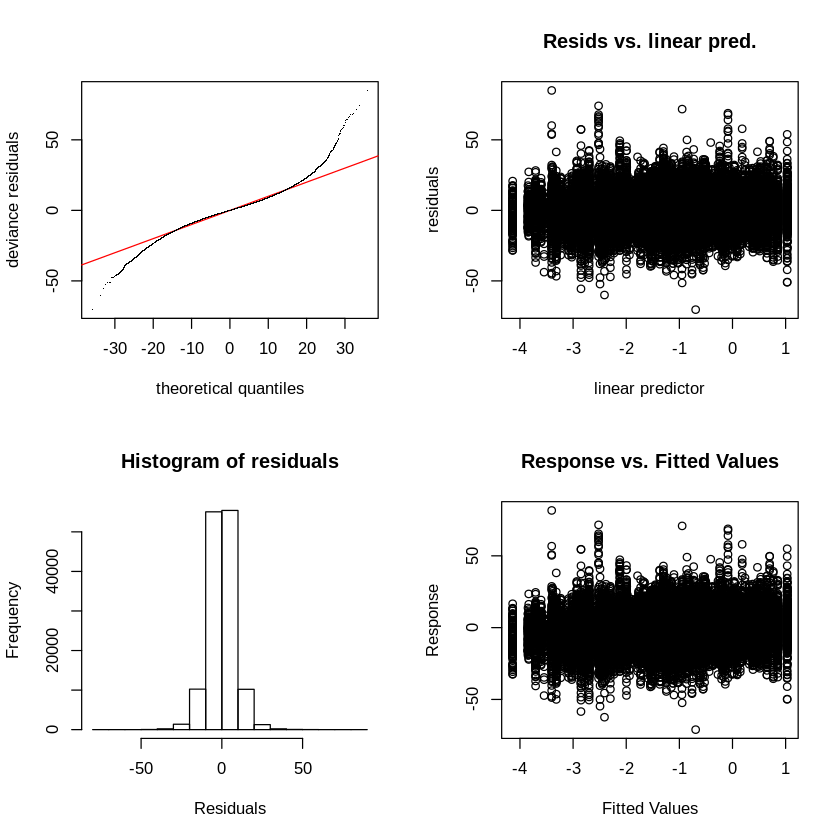

In [19]:
gam.check(m0)


Method: fREML   Optimizer: perf newton
full convergence after 7 iterations.
Gradient range [-0.000097719,0.000086585]
(score 439845 & scale 48.497).
Hessian positive definite, eigenvalue range [22.369,65440].
Model rank =  58 / 58 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

          k'  edf k-index p-value
s(Subj) 48.0 45.9      NA      NA


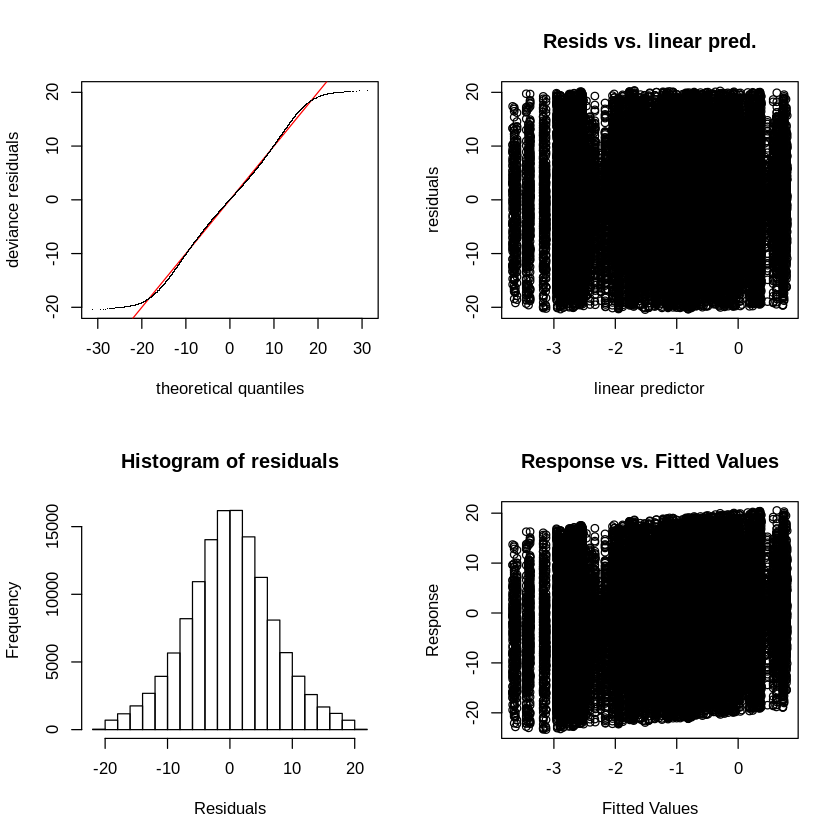

In [20]:
gam.check(m1)

## Compute cell means and CIs, and plot

In [21]:
bdat <- dat

In [22]:
dat <- subset(bdat, ROI == 'Frontal')

trialAvg = ddply(dat, 
                 .(Subj, MentalState, StimType),
                 summarize, 
                 Ampl = round(mean(meanAmpl), 3))


sumstats <- summarySEwithin(trialAvg, 
                            measurevar = "Ampl", 
                            withinvars = c("MentalState", "StimType"),
                            idvar = "Subj")

In [23]:
sumstats

MentalState,StimType,N,Ampl,Ampl_norm,sd,se,ci
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MW1,Oddball,35,-1.8995,-2.02838,2.2602,0.38205,0.77641
MW1,Standard,35,-1.0528,-1.18176,1.3796,0.23319,0.47390
MW2,Oddball,48,-1.5115,-1.46635,2.2586,0.32601,0.65584
MW2,Standard,48,-1.2086,-1.16347,1.4313,0.20659,0.41560
MW3,Oddball,43,-2.6130,-2.46670,2.7962,0.42641,0.86053
MW3,Standard,43,-1.0891,-0.94286,1.7615,0.26862,0.54210
MW4,Oddball,37,-2.3031,-2.30042,3.1878,0.52407,1.06286
MW4,Standard,37,-1.1018,-1.09918,1.8890,0.31056,0.62984
MW5,Oddball,14,-1.0743,-1.31525,4.4224,1.18195,2.55344


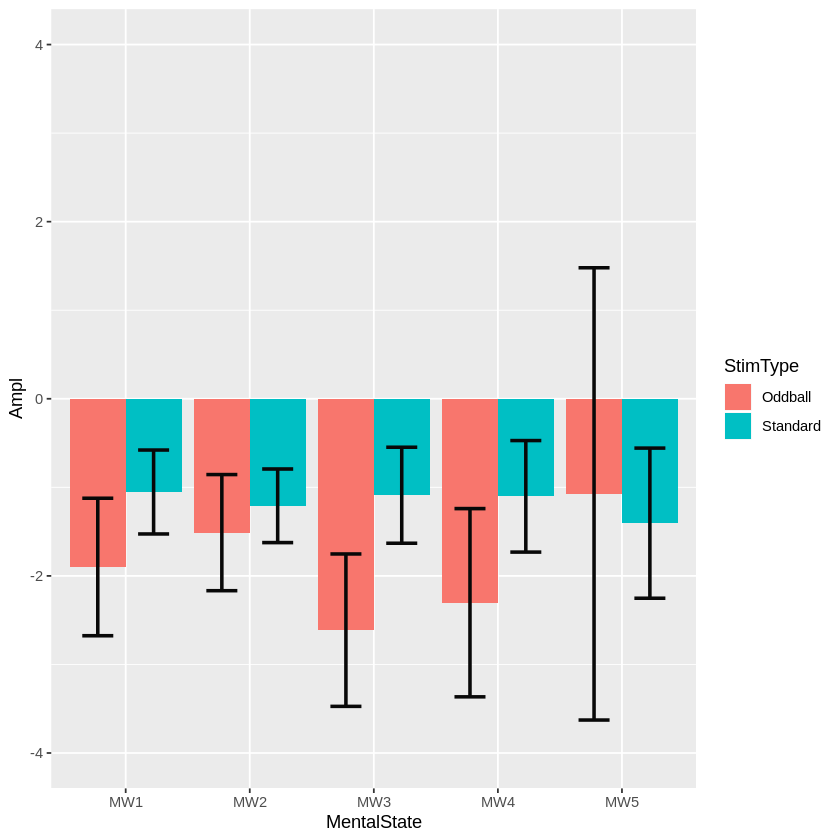

In [24]:
ggplot(sumstats, aes(y=Ampl, x=MentalState, fill=StimType)) + 
        geom_bar(position='dodge', stat='identity' ) +
        geom_errorbar(aes(ymin = Ampl - ci, ymax = Ampl + ci), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ylim(-4,4)

#ggsave(filename='2020-experiment-2-N1.png', dpi=600)


# GAMM analysis
### Compute the family of models we will consider, first contrasting random effects structures

In [25]:
cl <- makeCluster(num_cores)

m0 <- bam(meanAmpl ~ StimType * MentalState 
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m1f <- bam(meanAmpl ~ StimType  
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m2f <- bam(meanAmpl ~ MentalState 
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

In [26]:
AICtab = as.data.frame(AIC(m0,m1f,m2f))
minAIC =  min(AIC(m0,m1f,m2f)[2]) 

AICtab$deltaAIC = lapply(AICtab$AIC, deltaAICfunc)
AICtab$deltaAIC = as.numeric(AICtab$deltaAIC)

AICtab$L= lapply(AICtab$deltaAIC, f)
AICtab$L = as.numeric(AICtab$L)

sumlike = sum(AICtab$L)

AICtab$wAIC = lapply(AICtab$L, wAICfunc)
AICtab$wAIC = as.numeric(AICtab$wAIC)

# compute relative likelihood of each model relative to model with smallest AIC/max wAIC
# So, xBetter is interpreted as "the best model is x times more likely than this model"
wAICmax = max(AICtab$wAIC)
AICtab$xBetter = lapply(AICtab$wAIC, xBetterfunc)
AICtab$xBetter = as.numeric(AICtab$xBetter)

AICtab = AICtab[order(AICtab$deltaAIC),] 
AICtab[,c('df','AIC','deltaAIC','xBetter')]

,df,AIC,deltaAIC,xBetter
,<dbl>,<dbl>,<dbl>,<dbl>
m0,56.277,295642,0.000,1.00
m1f,48.289,295652,10.024,150.17
m2f,51.282,295737,95.058,438170096107767332864.00


In [27]:
summary(dat)

     epoch      MentalState     StimType          Subj          channel    
 Min.   : 171   MW1:10228   Oddball : 6906   03     :  956   C3     :7303  
 1st Qu.: 493   MW2:13462   Standard:36334   15     :  956   C4     :7303  
 Median :1945   MW3: 9878                    23     :  948   F4     :7218  
 Mean   :1686   MW4: 7181                    10     :  943   F3     :7199  
 3rd Qu.:2616   MW5: 2491                    18     :  940   Cz     :7123  
 Max.   :3384                                27     :  938   Fz     :7094  
                                             (Other):37559   (Other):   0  
    meanAmpl             ROI        electrodebySubj     StimTypebySubj 
 Min.   :-23.32   Occipital:    0   03_C4  :  160   02_Standard:  817  
 1st Qu.: -6.10   Parietal :    0   03_F4  :  160   10_Standard:  817  
 Median : -1.18   Frontal  :43240   15_F3  :  160   35_Standard:  817  
 Mean   : -1.27                     15_F4  :  160   06_Standard:  811  
 3rd Qu.:  3.66                 

## Compute LME based on model StimType * MentalState
- On task is significantly more negative for oddball condition, as before
- No significant differences for standards, as before

In [28]:
# relevel data to focus on standard and MW1

dat[,'MentalState'] <- relevel(dat[,'MentalState'],'MW1')
dat[,'StimType'] <- relevel(dat[,'StimType'],'Standard')

### Try many models

In [29]:
cl <- makeCluster(num_cores)

m1r <- bam(meanAmpl ~ StimType * MentalState   
          + s(Subj, bs="re") 
           + s(electrodebySubj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m2r <- bam(meanAmpl ~ StimType * MentalState   
          + s(Subj, bs="re") 
           + s(StimTypebySubj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m3r <- bam(meanAmpl ~ StimType * MentalState   
          + s(Subj, bs="re") 
           + s(MentalStatebySubj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m4r <- bam(meanAmpl ~ StimType * MentalState  
           + s(Subj, bs="re") 
           + s(electrodebySubj, bs="re")  
           + s(StimTypebySubj, bs="re"), 
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m5r <- bam(meanAmpl ~ StimType * MentalState  
           + s(Subj, bs="re") 
           + s(electrodebySubj, bs="re")  
           + s(MentalStatebySubj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m6r <- bam(meanAmpl ~ StimType * MentalState  
           + s(Subj, bs="re") 
           + s(StimTypebySubj, bs="re") 
           + s(MentalStatebySubj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

### Select best model based on AIC

In [30]:
AICtab = as.data.frame(AIC(m0,m1r,m2r,m3r,m4r,m5r,m6r))
minAIC =  min(AIC(m0,m1r,m2r,m3r,m4r,m5r,m6r)[2]) 

AICtab$deltaAIC = lapply(AICtab$AIC, deltaAICfunc)
AICtab$deltaAIC = as.numeric(AICtab$deltaAIC)

AICtab$L= lapply(AICtab$deltaAIC, f)
AICtab$L = as.numeric(AICtab$L)

sumlike = sum(AICtab$L)

AICtab$wAIC = lapply(AICtab$L, wAICfunc)
AICtab$wAIC = as.numeric(AICtab$wAIC)

# compute relative likelihood of each model relative to model with smallest AIC/max wAIC
# So, xBetter is interpreted as "the best model is x times more likely than this model"
wAICmax = max(AICtab$wAIC)
AICtab$xBetter = lapply(AICtab$wAIC, xBetterfunc)
AICtab$xBetter = as.numeric(AICtab$xBetter)

AICtab = AICtab[order(AICtab$deltaAIC),] 
AICtab[,c('df','AIC','deltaAIC','xBetter')]

,df,AIC,deltaAIC,xBetter
,<dbl>,<dbl>,<dbl>,<dbl>
m6r,193.718,295112,0.00,1.0000e+00
m3r,152.635,295338,225.94,1.1520e+49
m5r,152.638,295338,225.94,1.1538e+49
m2r,94.988,295444,331.14,8.0518e+71
m4r,94.992,295444,331.14,8.0709e+71
m0,56.277,295642,529.37,8.9567e+114
m1r,56.278,295642,529.38,8.9653e+114


### Get summary of the best model
Main effects and interactions. 

In [49]:
mod = m6r

mod_summary = anova(mod)
capture.output(mod_summary, file=paste(outdir, 'ANOVA_table ', CurTimeWin, 
                                       '.txt' ,sep=''))

mod_summary


Family: gaussian 
Link function: identity 

Formula:
meanAmpl ~ StimType * MentalState + s(Subj, bs = "re") + s(StimTypebySubj, 
    bs = "re") + s(MentalStatebySubj, bs = "re")

Parametric Terms:
                     df     F p-value
StimType              1 10.58  0.0011
MentalState           4  0.34  0.8522
StimType:MentalState  4  3.43  0.0083

Approximate significance of smooth terms:
                       edf Ref.df     F    p-value
s(Subj)               28.1   47.0 288.1 0.00000059
s(StimTypebySubj)     50.5   94.0  39.8     0.2773
s(MentalStatebySubj) 103.2  173.0  12.8     0.0026

In [50]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
meanAmpl ~ StimType * MentalState + s(Subj, bs = "re") + s(StimTypebySubj, 
    bs = "re") + s(MentalStatebySubj, bs = "re")

Parametric coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     -1.1330     0.3084   -3.67  0.00024 ***
StimTypeOddball                 -1.0212     0.3140   -3.25  0.00114 ** 
MentalStateMW2                  -0.0506     0.2571   -0.20  0.84402    
MentalStateMW3                   0.1159     0.2727    0.43  0.67077    
MentalStateMW4                   0.0144     0.2900    0.05  0.96032    
MentalStateMW5                  -0.3048     0.3952   -0.77  0.44054    
StimTypeOddball:MentalStateMW2   0.5819     0.2851    2.04  0.04127 *  
StimTypeOddball:MentalStateMW3  -0.3318     0.3204   -1.04  0.30041    
StimTypeOddball:MentalStateMW4  -0.0134     0.3482   -0.04  0.96931    
StimTypeOddball:MentalStateMW5   0.7301     0.5110    1.43  0.15311    
---

### Visualize these results

In [52]:
res <- t(summary(mod)$p.table[3,])
res <- as.data.frame(res)
res$Condition = paste("2 (Somewhat OT)")
posthocs <- res

res <- t(summary(mod)$p.table[4,])
res <- as.data.frame(res)
res$Condition = paste("3 (Neither OT nor MW)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[5,])
res <- as.data.frame(res)
res$Condition = paste("4 (Somewhat MW)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[6,])
res <- as.data.frame(res)
res$Condition = paste("5 (Completely MW)")
posthocs <- rbind(posthocs, res)

colnames(posthocs)[2] <- 'SE'
colnames(posthocs)[4] <- 'p (raw)'

# CIs
ncomp  <- dim(posthocs)[1] #-2 # The -2 is bc the age x polynomial contrasts are repeated for each group, but are teh same
thr <- adjust.se(alpha=0.05, df=1000, ncomp=ncomp)
posthocs$CIup <- round(posthocs$Estimate + thr * posthocs$SE, 2)
posthocs$CIdown <- round(posthocs$Estimate - thr * posthocs$SE, 2)

# Round for pretty table
posthocs[,'Estimate'] = round(posthocs[,'Estimate'],2)
posthocs[,'SE'] = round(posthocs[,'SE'],3)
posthocs[,'t value'] = round(posthocs[,'t value'],2)
posthocs[,'p (raw)'] = round(posthocs[,'p (raw)'],5)

# Reorder columns
posthocs = posthocs[,c('Condition', 'Estimate','SE','CIup','CIdown','t value','p (raw)')]


# Multiple comparison correction
posthocs$'p (Holm)'     <- round(p.adjust(posthocs$'p (raw)', method='holm', n <- ncomp), 4)

# write.csv(posthocs, file=paste(topdir, '/', expt, '_output/', 'stats ', CurTimeWin, 
#                                ' posthocs 4way BxGxVxR.csv' ,sep=''))

posthocs

Condition,Estimate,SE,CIup,CIdown,t value,p (raw),p (Holm)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2 (Somewhat OT),-0.05,0.257,0.59,-0.69,-0.20,0.84402,1
3 (Neither OT nor MW),0.12,0.273,0.80,-0.57,0.43,0.67077,1
4 (Somewhat MW),0.01,0.290,0.74,-0.71,0.05,0.96032,1
5 (Completely MW),-0.30,0.395,0.68,-1.29,-0.77,0.44054,1


Saving 6.67 x 6.67 in image


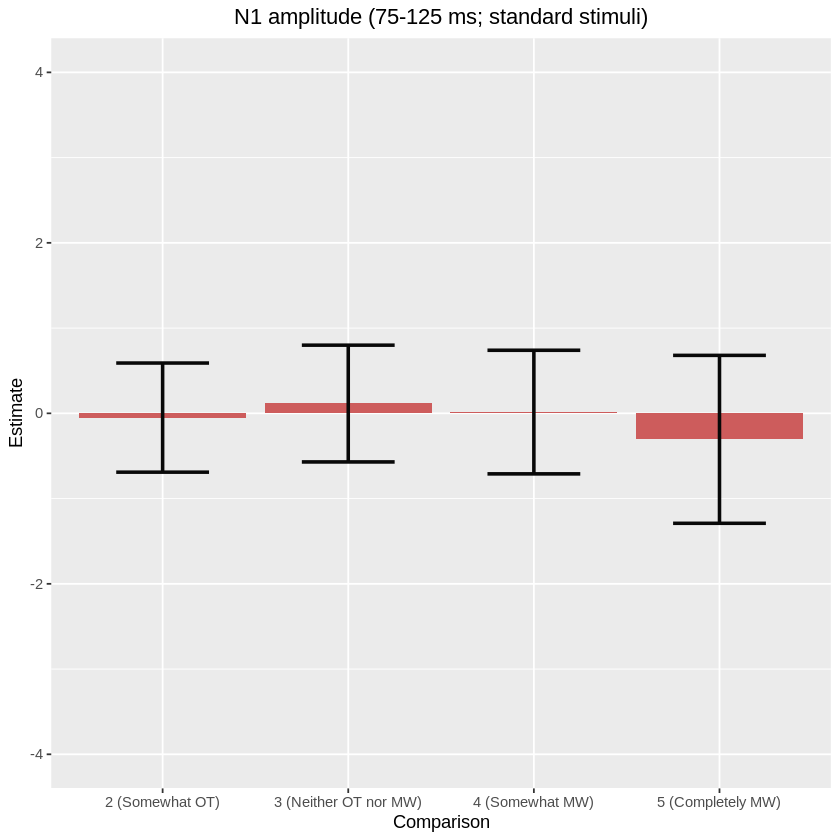

In [53]:
ggplot(posthocs, aes(x=Condition, y=Estimate)) + 
        geom_bar(position='dodge', stat='identity', fill='indianred' ) +
        geom_errorbar(aes(ymin = CIdown, ymax = CIup), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ylim(-4,4) + 
        ggtitle("N1 amplitude (75-125 ms; standard stimuli)") +
        theme(plot.title = element_text(hjust=0.5)) +
        xlab("Comparison")


ggsave(filename='standard-n1.png', dpi=600)

### Level around MW1 oddball instead

In [35]:
# relevel data to focus on standard and MW1

dat[,'MentalState'] <- relevel(dat[,'MentalState'],'MW1')
dat[,'StimType'] <- relevel(dat[,'StimType'],'Oddball')

cl <- makeCluster(num_cores)

m7r <- bam(meanAmpl ~ StimType * MentalState  
           + s(Subj, bs="re") 
           + s(StimTypebySubj, bs="re") 
           + s(MentalStatebySubj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

In [45]:
mod = m7r

mod_summary = anova(mod)
capture.output(mod_summary, file=paste(outdir, 'ANOVA_table ', CurTimeWin, 
                                       '.txt' ,sep=''))

mod_summary


Family: gaussian 
Link function: identity 

Formula:
meanAmpl ~ StimType * MentalState + s(Subj, bs = "re") + s(StimTypebySubj, 
    bs = "re") + s(MentalStatebySubj, bs = "re")

Parametric Terms:
                     df     F p-value
StimType              1 10.58  0.0011
MentalState           4  1.52  0.1935
StimType:MentalState  4  3.43  0.0083

Approximate significance of smooth terms:
                       edf Ref.df     F    p-value
s(Subj)               28.1   47.0 288.1 0.00000059
s(StimTypebySubj)     50.5   94.0  39.8     0.2773
s(MentalStatebySubj) 103.2  173.0  12.8     0.0026

In [46]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
meanAmpl ~ StimType * MentalState + s(Subj, bs = "re") + s(StimTypebySubj, 
    bs = "re") + s(MentalStatebySubj, bs = "re")

Parametric coefficients:
                                Estimate Std. Error t value    Pr(>|t|)    
(Intercept)                     -2.15415    0.35908   -6.00 0.000000002 ***
StimTypeStandard                 1.02115    0.31395    3.25      0.0011 ** 
MentalStateMW2                   0.53130    0.34883    1.52      0.1277    
MentalStateMW3                  -0.21586    0.37835   -0.57      0.5683    
MentalStateMW4                   0.00103    0.40563    0.00      0.9980    
MentalStateMW5                   0.42527    0.57925    0.73      0.4629    
StimTypeStandard:MentalStateMW2 -0.58189    0.28512   -2.04      0.0413 *  
StimTypeStandard:MentalStateMW3  0.33177    0.32037    1.04      0.3004    
StimTypeStandard:MentalStateMW4  0.01340    0.34818    0.04      0.9693    
StimTypeStandard:MentalStateMW5 -0.

### Visualize the results

In [47]:
res <- t(summary(mod)$p.table[3,])
res <- as.data.frame(res)
res$Condition = paste("2 (Somewhat OT)")
posthocs <- res

res <- t(summary(mod)$p.table[4,])
res <- as.data.frame(res)
res$Condition = paste("3 (Neither OT nor MW)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[5,])
res <- as.data.frame(res)
res$Condition = paste("4 (Somewhat MW)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[6,])
res <- as.data.frame(res)
res$Condition = paste("5 (Completely MW)")
posthocs <- rbind(posthocs, res)

colnames(posthocs)[2] <- 'SE'
colnames(posthocs)[4] <- 'p (raw)'

# CIs
ncomp  <- dim(posthocs)[1] #-2 # The -2 is bc the age x polynomial contrasts are repeated for each group, but are teh same
thr <- adjust.se(alpha=0.05, df=1000, ncomp=ncomp)
posthocs$CIup <- round(posthocs$Estimate + thr * posthocs$SE, 2)
posthocs$CIdown <- round(posthocs$Estimate - thr * posthocs$SE, 2)

# Round for pretty table
posthocs[,'Estimate'] = round(posthocs[,'Estimate'],2)
posthocs[,'SE'] = round(posthocs[,'SE'],3)
posthocs[,'t value'] = round(posthocs[,'t value'],2)
posthocs[,'p (raw)'] = round(posthocs[,'p (raw)'],5)

# Reorder columns
posthocs = posthocs[,c('Condition', 'Estimate','SE','CIup','CIdown','t value','p (raw)')]


# Multiple comparison correction
posthocs$'p (Holm)'     <- round(p.adjust(posthocs$'p (raw)', method='holm', n <- ncomp), 4)

# write.csv(posthocs, file=paste(topdir, '/', expt, '_output/', 'stats ', CurTimeWin, 
#                                ' posthocs 4way BxGxVxR.csv' ,sep=''))

posthocs

Condition,Estimate,SE,CIup,CIdown,t value,p (raw),p (Holm)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2 (Somewhat OT),0.53,0.349,1.40,-0.34,1.52,0.12774,0.511
3 (Neither OT nor MW),-0.22,0.378,0.73,-1.16,-0.57,0.56832,1.000
4 (Somewhat MW),0.00,0.406,1.02,-1.01,0.00,0.99797,1.000
5 (Completely MW),0.43,0.579,1.87,-1.02,0.73,0.46285,1.000


Saving 6.67 x 6.67 in image


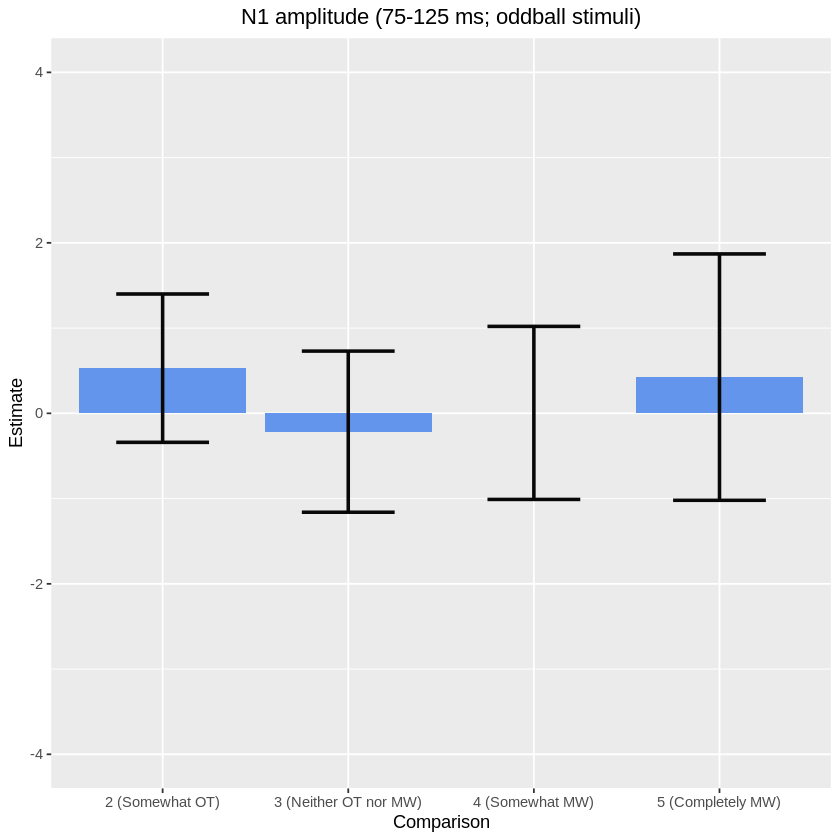

In [48]:
ggplot(posthocs, aes(x=Condition, y=Estimate)) + 
        geom_bar(position='dodge', stat='identity', fill='cornflowerblue' ) +
        geom_errorbar(aes(ymin = CIdown, ymax = CIup), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ylim(-4,4) + 
        ggtitle("N1 amplitude (75-125 ms; oddball stimuli)") +
        theme(plot.title = element_text(hjust=0.5)) +
        xlab("Comparison")

ggsave(filename='oddball-n1.png', dpi=600)